#**Group Name**:MI4

#**Group Members**:Anuja Negi, Debapratim Jana, Tobiasz Budzynski,Muthukumar Pandaram

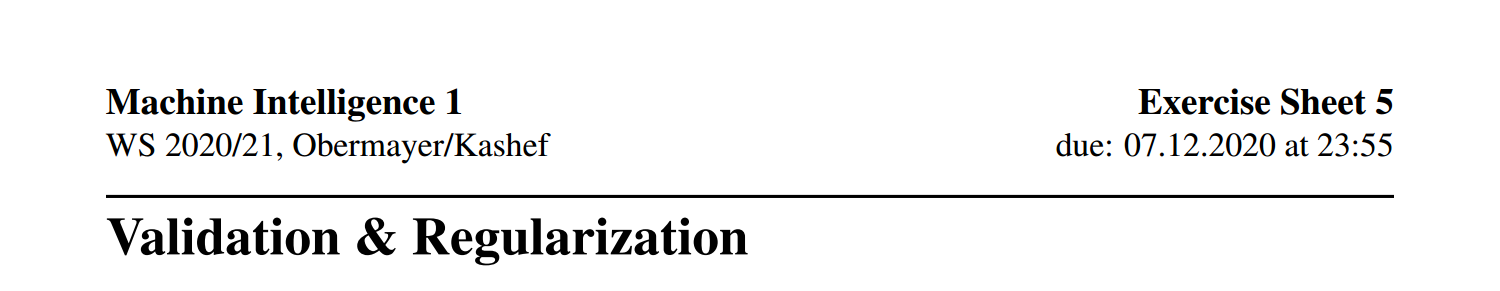

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl

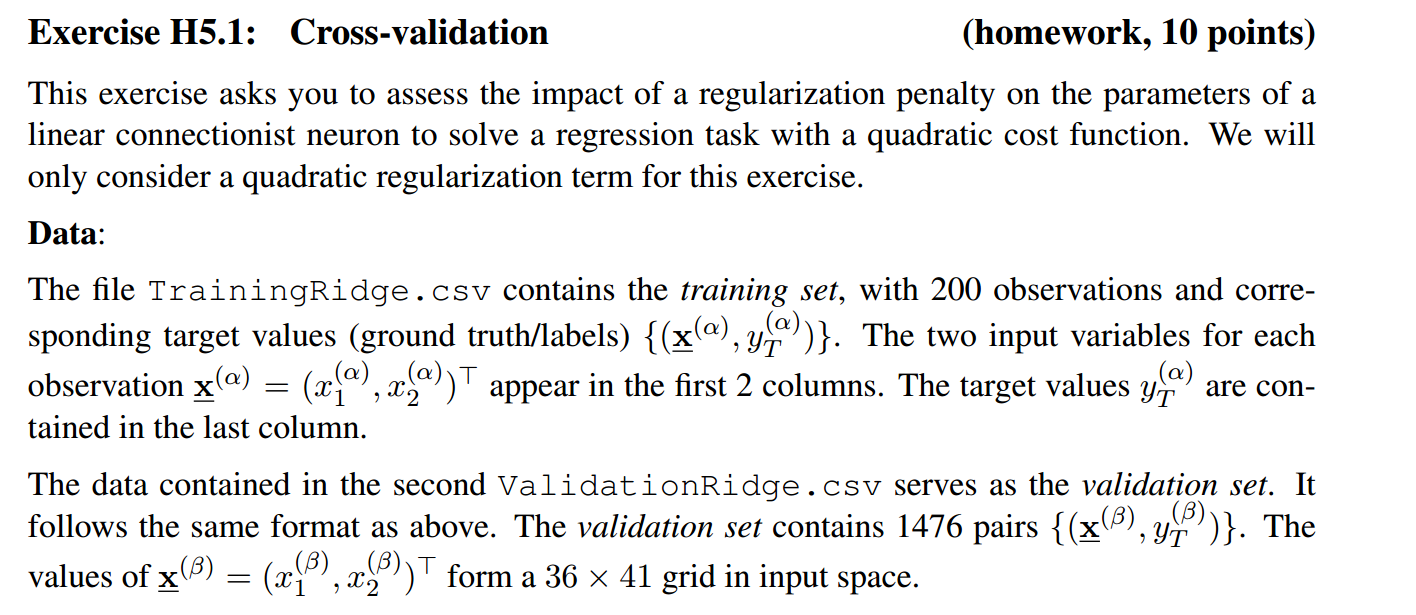

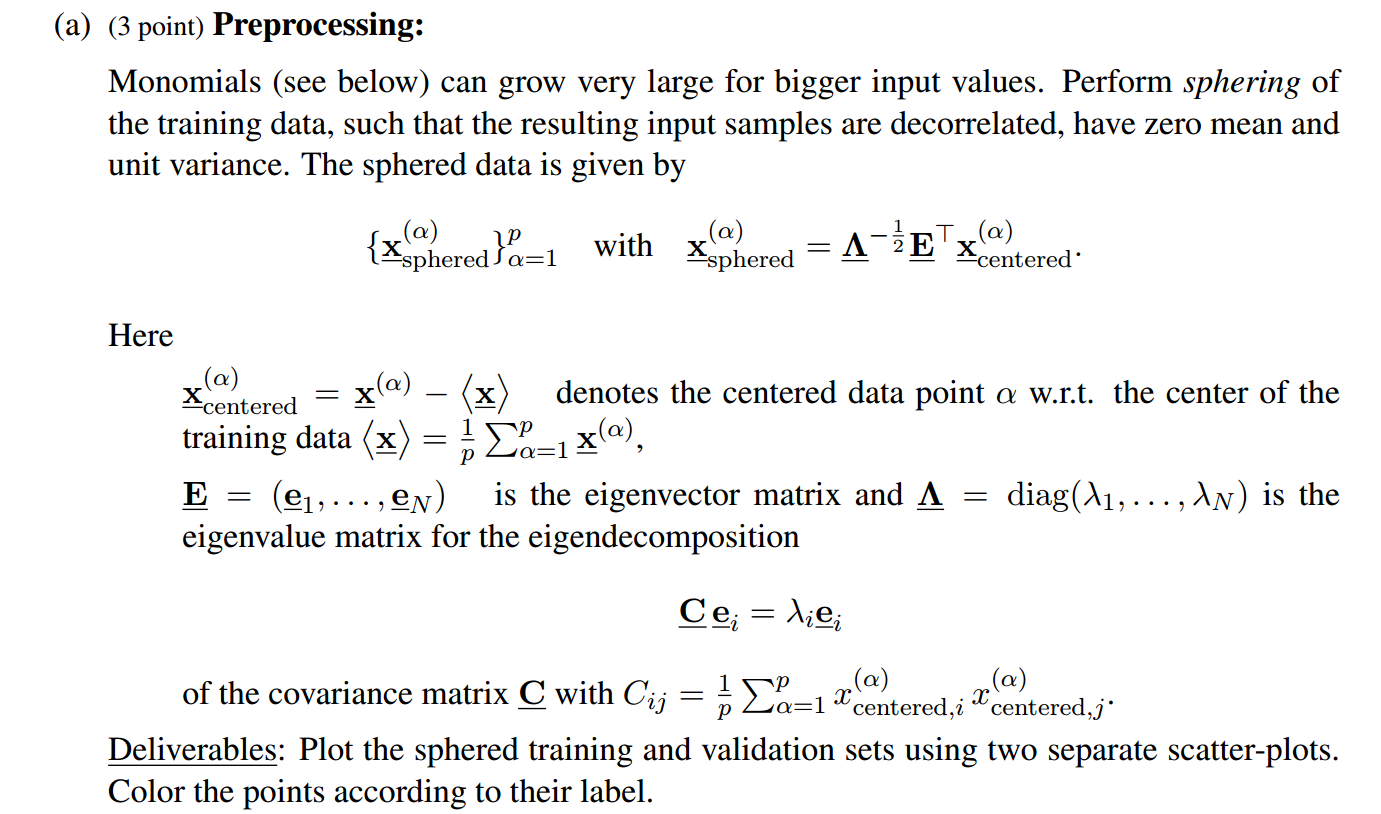

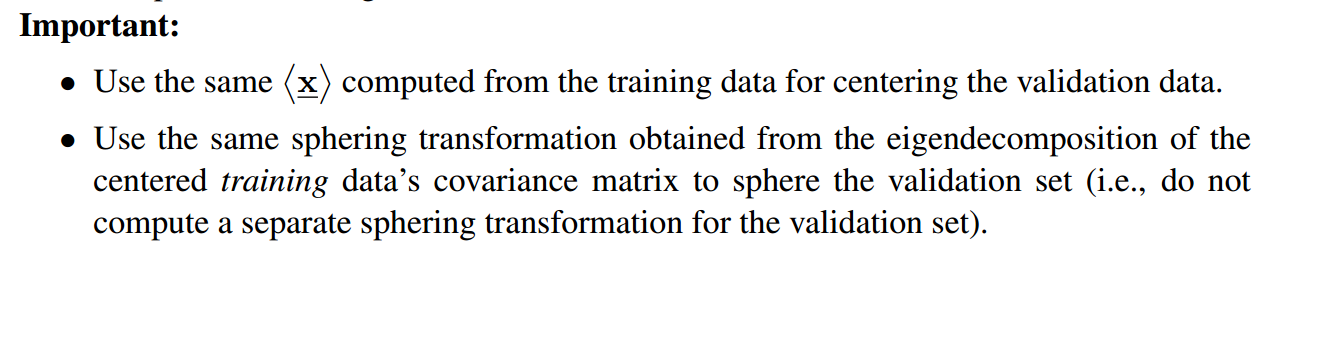

In [2]:
#Loading data
TrainingRidge=np.genfromtxt('/content/TrainingRidge.csv',delimiter=',',dtype=np.float, skip_header=1)
ValidationRidge=np.genfromtxt('/content/ValidationRidge.csv',delimiter=',',dtype=np.float, skip_header=1)
x_train=TrainingRidge[:,0:2]
y_train=TrainingRidge[:,-1]
x_validate=ValidationRidge[:,0:2]
y_validate=ValidationRidge[:,-1]

In [3]:
def plot_with_labels(x,y,input_name):
    N=int(round(np.max(y)))
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    bounds = np.linspace(0,N+1,N+2)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    scat=ax.scatter(x[:,0],x[:,1],c=y,cmap=cmap,norm=norm)
    
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Labels')
    plt.title('%s'%input_name)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.show()

    
    return scat

In [4]:
def center(x,x_mean):
    centered_x = x - x_mean
    return centered_x

def sphered(x_centered,validation=False):
    cov = np.cov(x_centered, rowvar=False, bias=True)
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eig_values, eig_vectors = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    x_decorrelated = x_centered.dot(eig_vectors)       #TB: community advises using @ or matmul
    # Rescale the decorrelated data
    x_sphered = x_decorrelated / np.sqrt(eig_values + 1e-8)

    return x_sphered,eig_values, eig_vectors

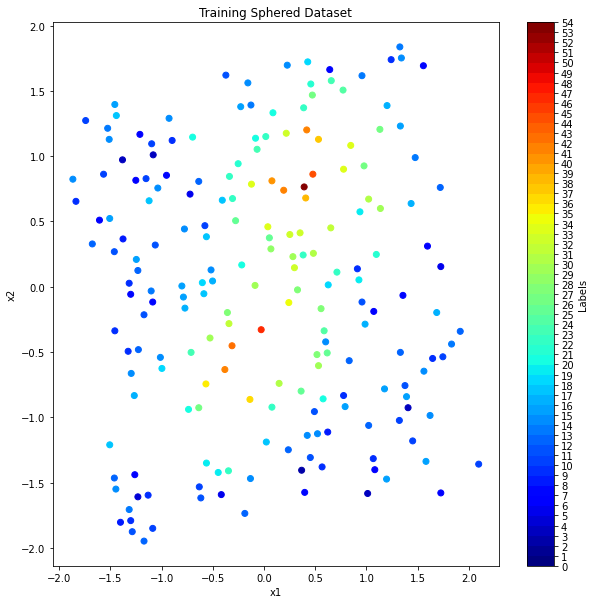

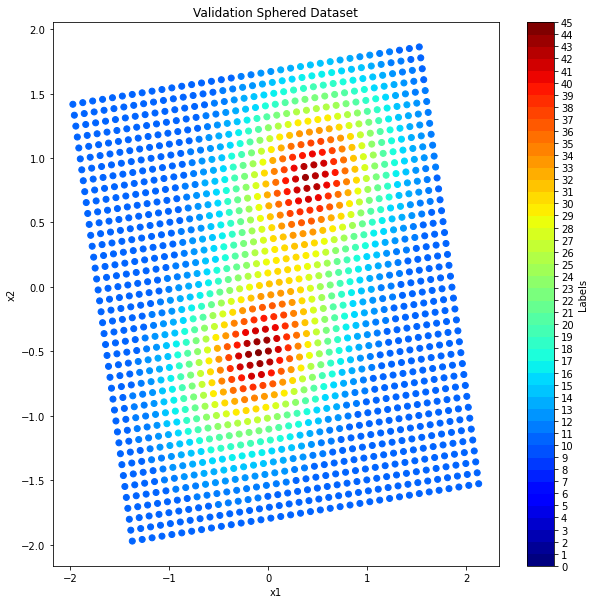

In [5]:
#Plotting sphered training 
x_train_mean = x_train.mean(axis=0)              
x_train_centered = center(x_train,x_train_mean)         #np.mean(x_train_centered) != [0,0] : ( 
x_train_sphered,eig_values_train,eig_vectors_train = sphered(x_train_centered)

scat_train_sphered=plot_with_labels(x_train_sphered,y_train,'Training Sphered Dataset')

#Plotting sphered validation sets
x_validate_centered=center(x_validate,x_train_mean)
x_validate_decorrelated = x_validate_centered.dot(eig_vectors_train)
x_validate_sphered = x_validate_decorrelated / np.sqrt(eig_values_train + 1e-5)

scat_validate_sphered=plot_with_labels(x_validate_sphered,y_validate,'Validation Sphered Dataset')


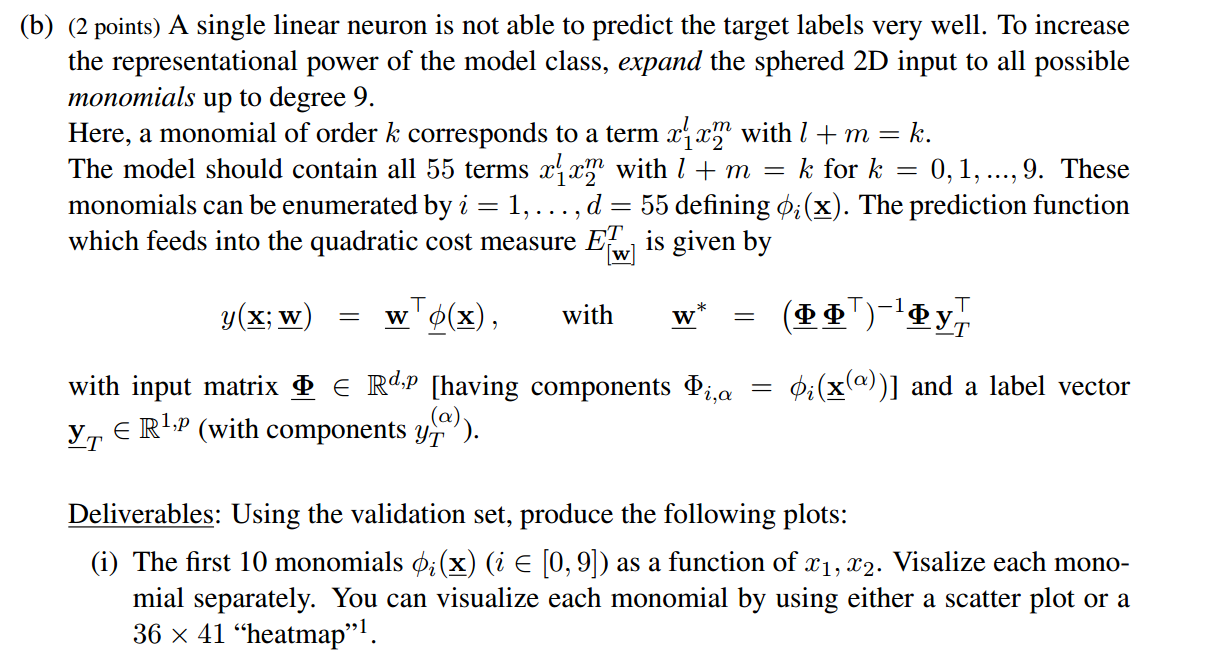

In [6]:
def calculate_monomials(degree,x):
    phi=[]
    for d in range(degree+1):
        for i in range(d+1):
            for j in range (d+1):                      
                if i+j==d:
                    phi.append(x[0]**i*x[1]**j)
    return np.array(phi)

def calculate_phi(x):
    phi_whole=np.empty((55,x.shape[0]))
    w_star=np.empty((55,1)) 

    for i in range(x.shape[0]):
        phi_whole[:,i]=calculate_monomials(9,x[i,:])  

    return phi_whole

def calculate_w_star(x,y):
    phi_whole=np.empty((55,x.shape[0]))                 
    w_star=np.empty((55,1))                             
                                                        
    for i in range(x.shape[0]):                         
        phi_whole[:,i]=calculate_monomials(9,x[i,:])    

    A=np.linalg.inv(np.matmul(phi_whole,phi_whole.T))
    B=np.matmul(phi_whole,y.T)
    w_star=np.matmul(A,B)
    
    return phi_whole,w_star

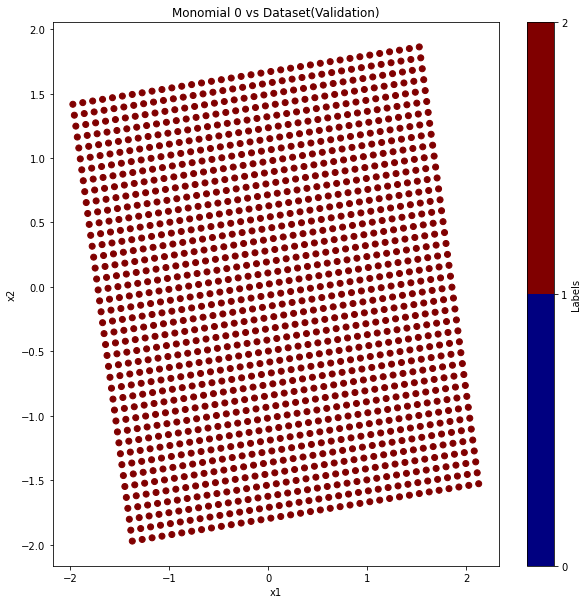

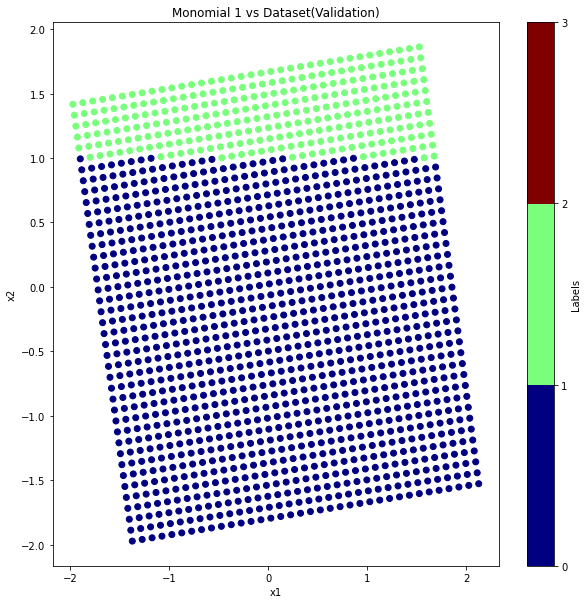

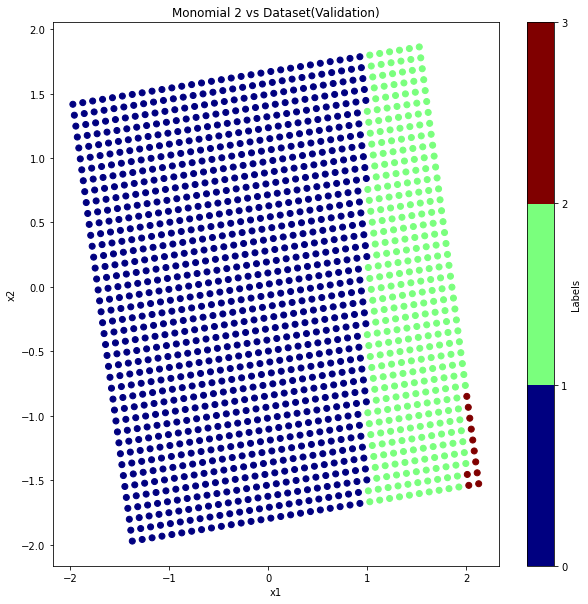

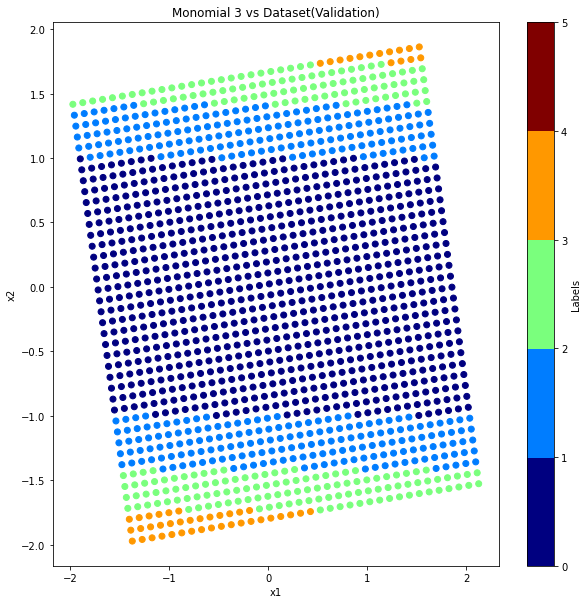

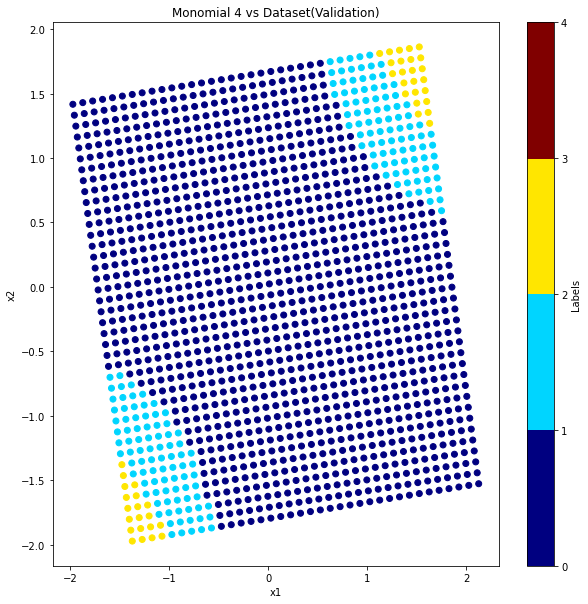

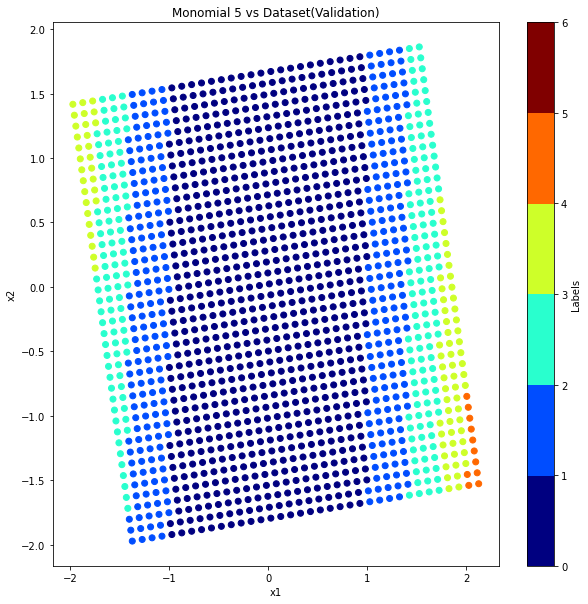

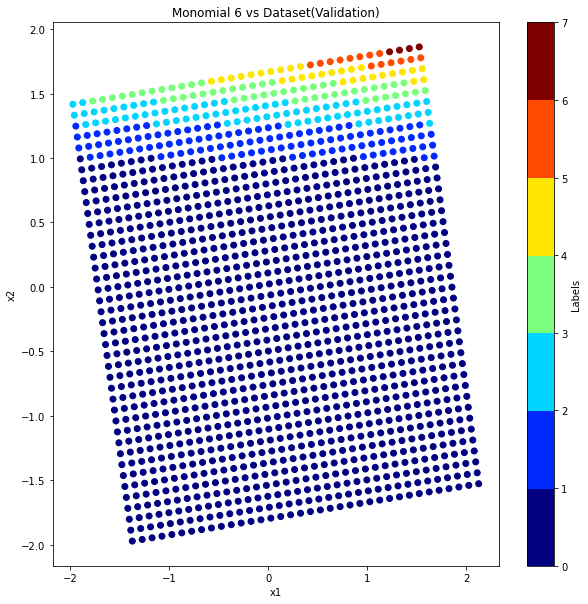

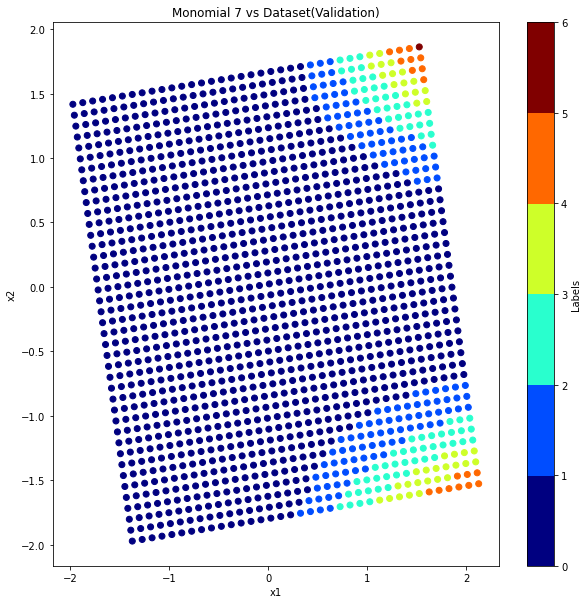

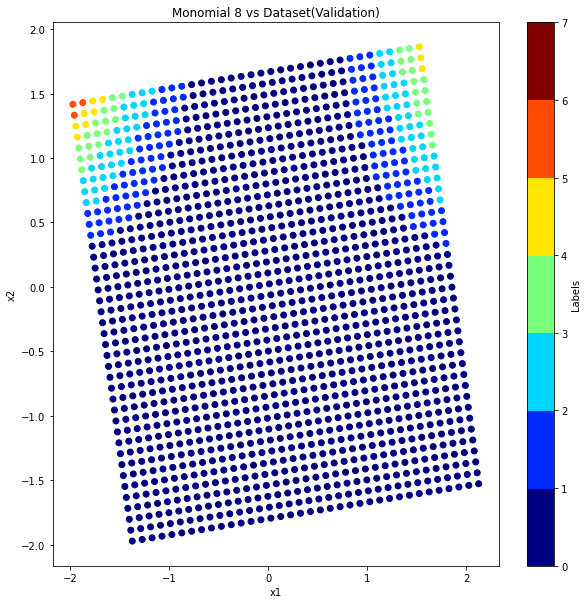

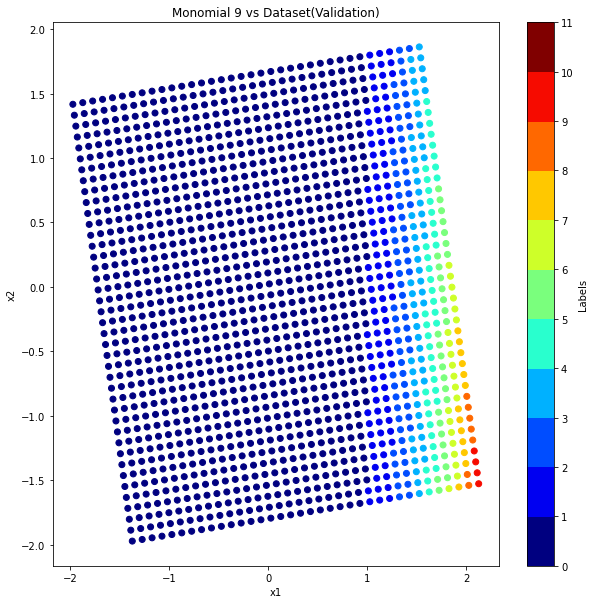

In [7]:
phi_train,w_star_train=calculate_w_star(x_train_sphered,y_train)
phi_validate,w_star_validate=calculate_w_star(x_validate_sphered,y_validate)


for i in range(10):
  plot_with_labels(x_validate_sphered,phi_validate[i,:],'Monomial %s vs Dataset(Validation)' %str(i))
  plt.show()


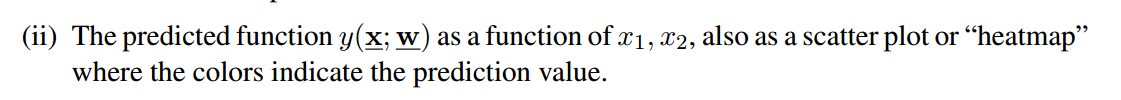

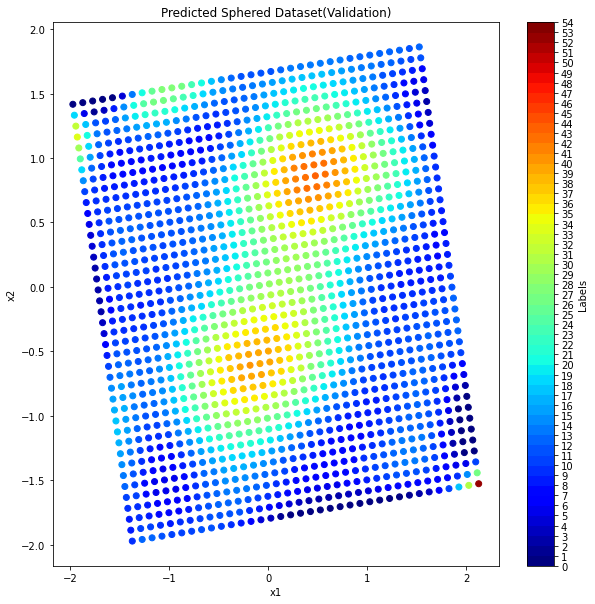

In [8]:
y_pred=np.matmul(w_star_train.T,phi_validate)

scat_pred_labels=plot_with_labels(x_validate_sphered,y_pred,'Predicted Sphered Dataset(Validation)')

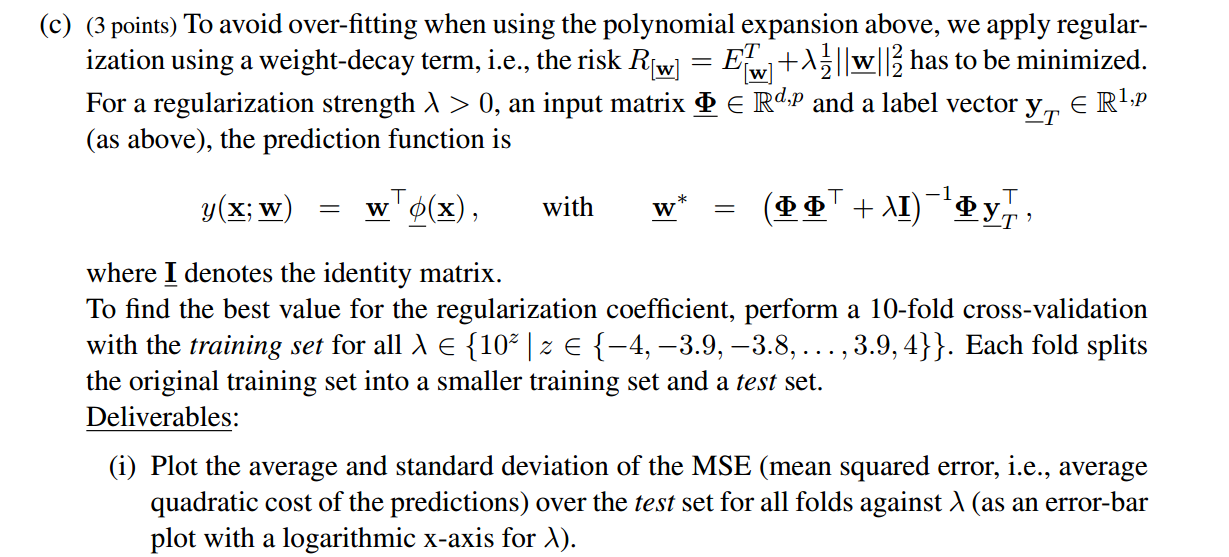

In [9]:

def calculate_reg_w_star(x,y, lambda_reg, training = True):        
    phi_whole=np.empty((55,x.shape[0]))
    reg_w_star=np.empty((55,1)) 

    for i in range(x.shape[0]):
        phi_whole[:,i]=calculate_monomials(9,x[i,:])  

    if training : 
        A=np.linalg.inv(np.matmul(phi_whole,phi_whole.T)  + lambda_reg*np.ones([55,55]))
        B=np.matmul(phi_whole,y.T)
        reg_w_star=np.matmul(A,B)
 
    return phi_whole,reg_w_star


In [10]:
from sklearn.model_selection import train_test_split


lambda_reg =  np.power(10, np.arange(-4, 4, 0.1))       # array containing regular coefficients
n = 10                                                  # n-cross validation

# Split the training data set into n chunks : (n-1) for weight optimization/training and 1 for testing/hyperparameter estimation. 
# added extra '_CV' suffix to avoid confusion with other variables.



def n_fold_cross_validation(n , lambda_reg, x , y ):

    mse_mean = []
    mse_std   = []

    for l in range(len(lambda_reg)):        # iterate over lambda 
        
        mse = []

        for i in range(n):

            X_train_CV, X_test_CV, Y_train_CV, Y_test_CV =  train_test_split(x , y,  test_size=(n/x.shape[0]) , shuffle=True)   # for each fold split 
            phi_train,reg_w_star = calculate_reg_w_star(X_train_CV, Y_train_CV, lambda_reg[l], training = True)                                              # train on train sunset

            phi_test = calculate_phi(X_test_CV)
            y_pred   = np.matmul(reg_w_star.T ,  phi_test)

            mse += [np.mean(0.5*(y_pred - Y_test_CV)**2)]
            
        mse_mean += [np.mean(mse)]

        mse_std  += [np.std(mse) ]    

    return mse_mean , mse_std 

mse_mean , mse_std  = n_fold_cross_validation( 10, lambda_reg ,  x_train_sphered , y_train)


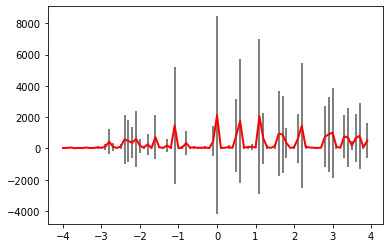

In [11]:
plt.errorbar(np.log10(lambda_reg) , mse_mean , mse_std , ecolor='gray' , lw =  2 , c = 'r' )
plt.show()

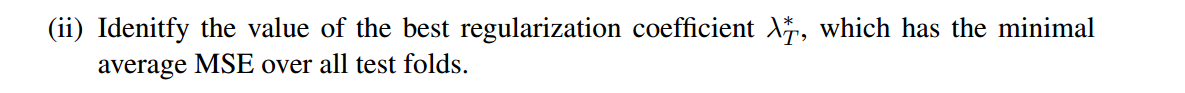

In [12]:
lambda_best = np.round(lambda_reg[np.argmin(mse_mean)] , 2)
mse_best = np.round(np.min(mse_mean) , 2)
print('Best regularization coefficient λ* is %s with best MSE of %s . ' % ( lambda_best , mse_best ))

Best regularization coefficient λ* is 0.1 with best MSE of 11.03 . 


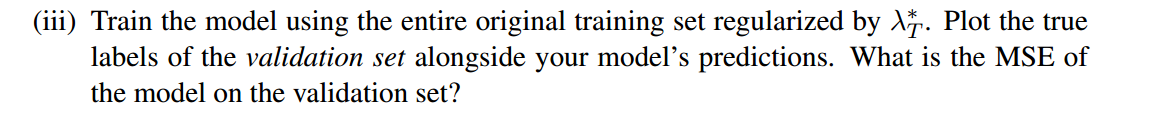

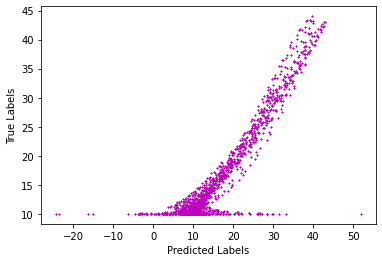

MSE on validation set: 8.014165443018653


In [13]:
phi_best , w_star_best =  calculate_reg_w_star(x_train_sphered, y_train, lambda_best , training = True)   
y_pred = np.matmul(w_star_best.T , phi_validate)

plt.scatter(y_pred, y_validate, marker= 'x' , s = 1.2, c = 'm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

mse_validate = np.mean(0.5*(y_pred - y_validate)**2)

print('MSE on validation set: %s' % mse_validate) 

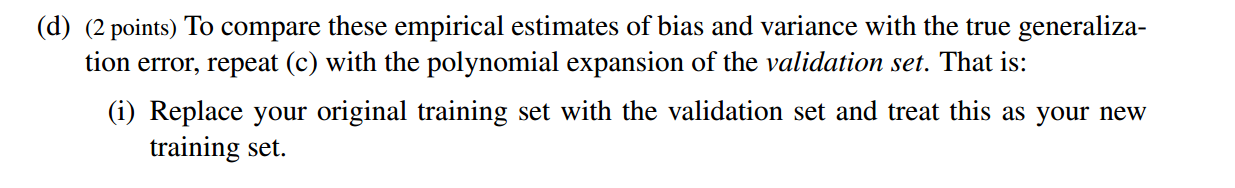

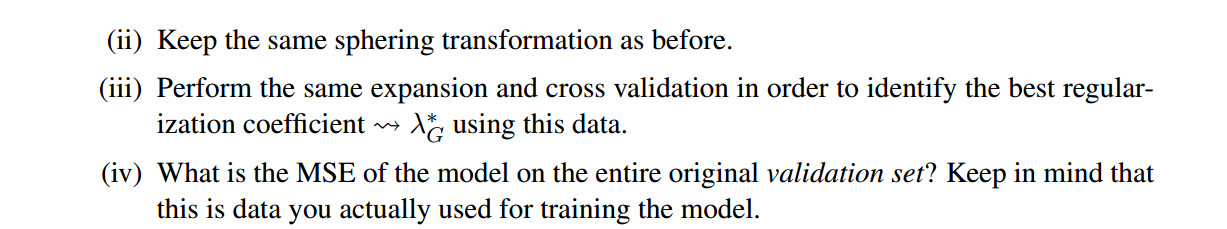

In [14]:
# (i) - (iii) expand

phi_validate_whole =calculate_phi(x_validate_sphered)

In [15]:
# ...(iii)     train

mse_validate_mean, mse_validate_std    =    n_fold_cross_validation( 
                                  10, lambda_reg, x_validate_sphered, y_validate)

In [16]:
#...(iii)       find

lambda_star_G = np.round(lambda_reg[np.argmin(mse_validate_mean)] , 4)
lambda_star_G   #equals ~zero

0.0025

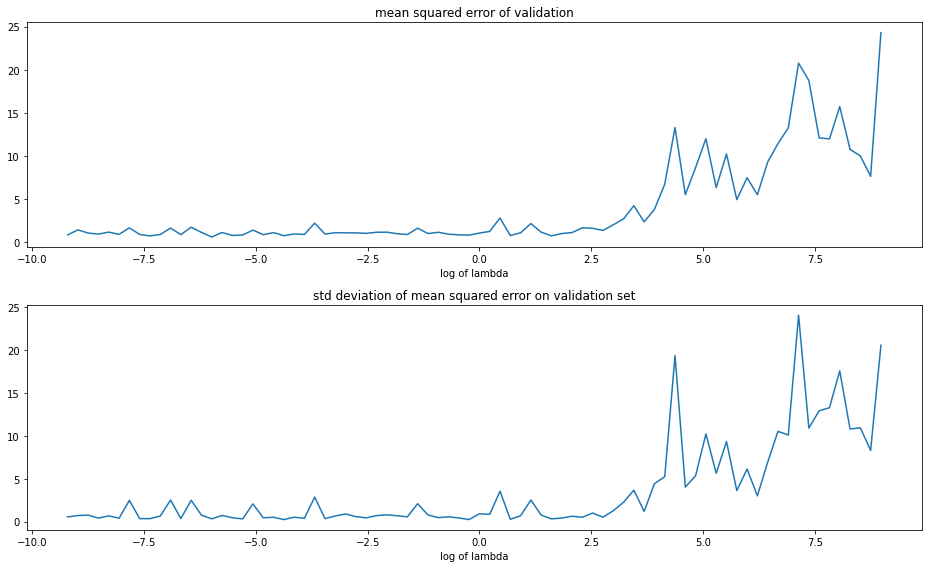

In [17]:
#
fig, axs = plt.subplots(2, figsize = (13,8))
axs[0].plot(np.log(lambda_reg), np.array(mse_validate_mean))
axs[0].set_xlabel("log of lambda")
axs[0].set_title("mean squared error of validation")
axs[1].plot(np.log(lambda_reg), mse_validate_std)
axs[1].set_xlabel("log of lambda")
axs[1].set_title("std deviation of mean squared error on validation set")

plt.tight_layout()

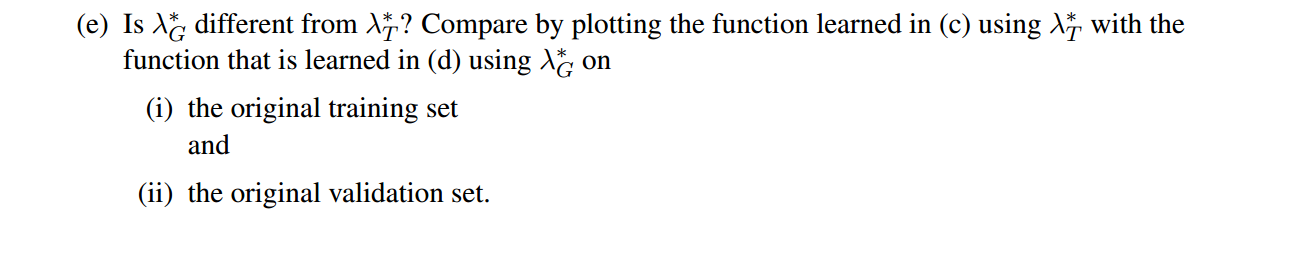

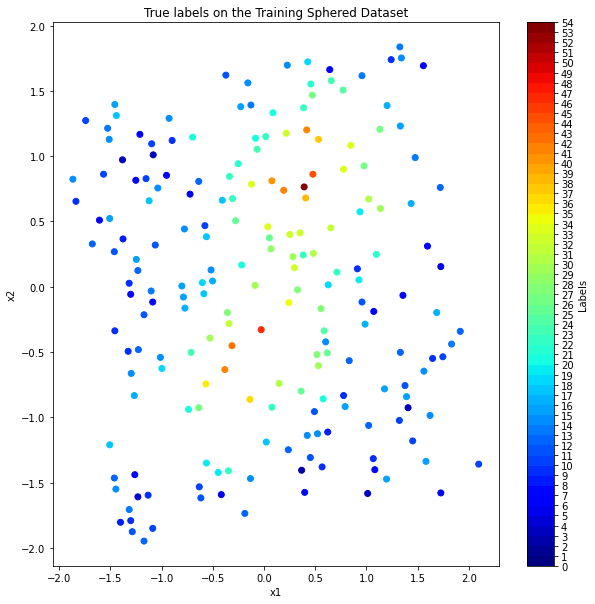

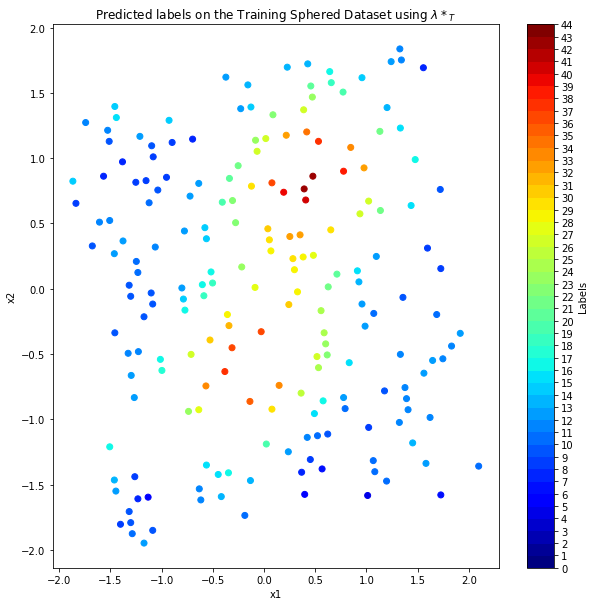

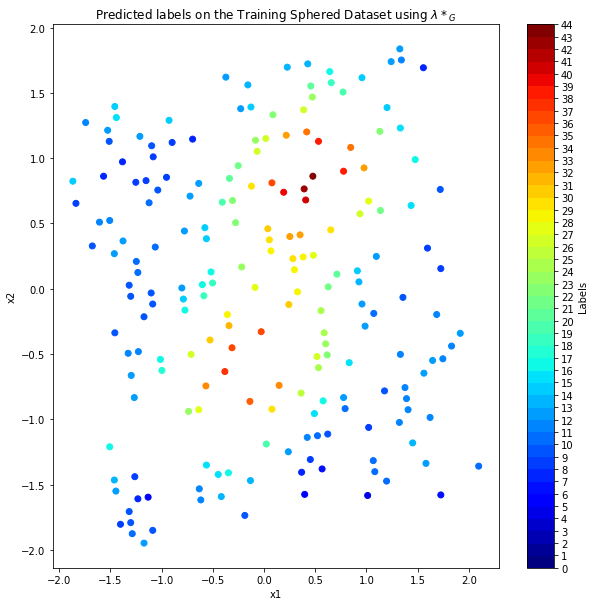

In [18]:
plot_with_labels(x_train_sphered,y_train,'True labels on the Training Sphered Dataset')

# using lambda_star_T
_ , w_star_best =  calculate_reg_w_star(x_train_sphered, y_train, lambda_best , training = True)   
y_pred = np.matmul(w_star_best.T , phi_train)
plot_with_labels(x_train_sphered,y_pred,'Predicted labels on the Training Sphered Dataset using $\lambda*_T$')


# using lambda_star_G
_ , w_star_best =  calculate_reg_w_star(x_train_sphered, y_train, lambda_star_G , training = True)   
y_pred = np.matmul(w_star_best.T , phi_train)
plot_with_labels(x_train_sphered,y_pred,'Predicted labels on the Training Sphered Dataset using $\lambda*_G$')

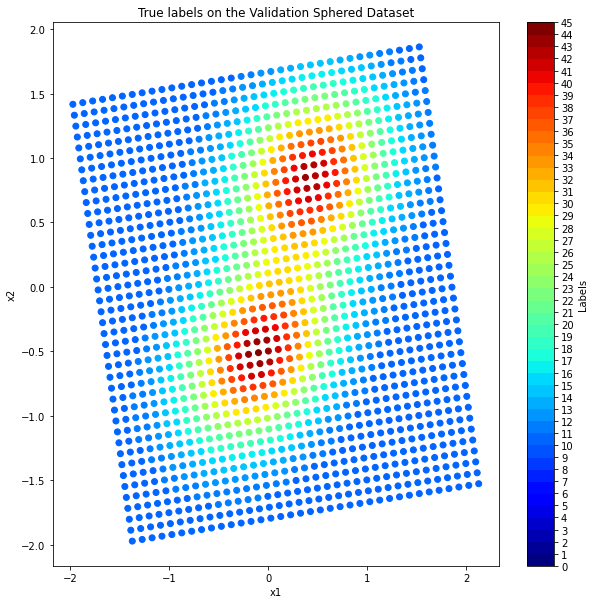

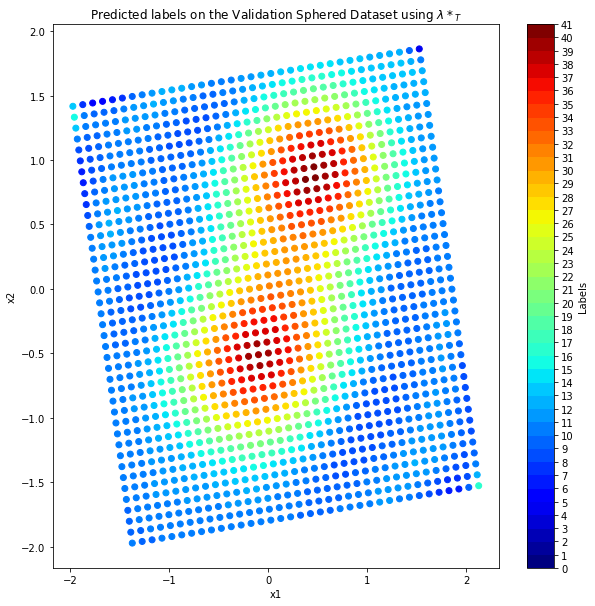

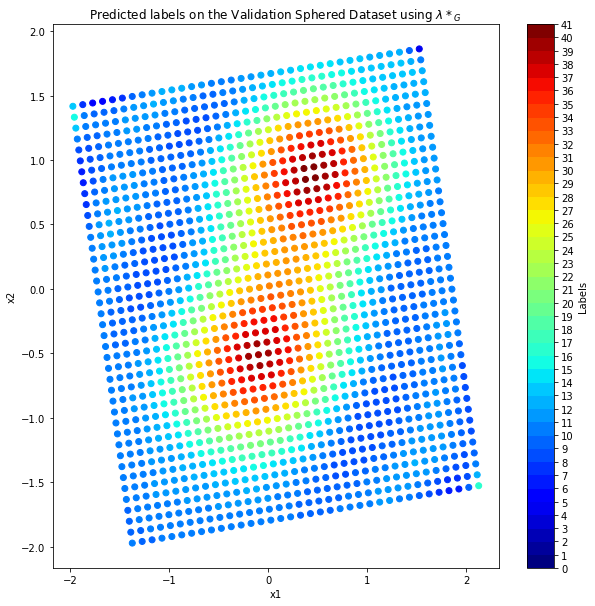

In [19]:
plot_with_labels(x_validate_sphered, y_validate,'True labels on the Validation Sphered Dataset')

# using lambda_star_T
_ , w_star_best =  calculate_reg_w_star(x_validate_sphered, y_validate, lambda_best , training = True)   
y_pred = np.matmul(w_star_best.T , phi_validate)
plot_with_labels(x_validate_sphered, y_pred,'Predicted labels on the Validation Sphered Dataset using $\lambda*_T$')


# using lambda_star_G
_ , w_star_best =  calculate_reg_w_star(x_validate_sphered, y_validate, lambda_star_G , training = True)   
y_pred = np.matmul(w_star_best.T , phi_validate)
plot_with_labels(x_validate_sphered, y_pred,'Predicted labels on the Validation Sphered Dataset using $\lambda*_G$')